<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/12_GPax_beyond_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GPax beyond 1D**

- Made by Maxim Ziatdinov (2022), https://scholar.google.com/citations?user=YnSdOoUAAAAJ
- Adapted by Yongtao Liu, https://scholar.google.com/citations?hl=en&user=V9FMPgQAAAAJ
- Collaboration with Mahshid Ahmadi, https://scholar.google.com/citations?hl=en&user=DNOfTQ0AAAAJ
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!

This notebook illustrates the Gaussian Processes, structured GP, and Hypothesis learning for the 2D case. This approach can be applied to the problems such as discovery of the phase diagrams of the hybrid perovskites, exploring the parameter spaces of complex Hamiltonians, and similar optimization tasks.   

In [1]:
#!pip install numpyro==0.10.0
#!pip install jax==0.4.2 jaxlib==0.4.2
#!pip install -q git+https://github.com/ziatdinovmax/gpax.git

!pip install gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 10.7 MB/s eta 0:00:00


In [2]:
# !pip install --upgrade jax==0.2.25  # currently, gpax doesn't work with jax-0.2.26
# !pip install -q git+https://github.com/ziatdinovmax/gpax.git
# !pip install git+https://github.com/ziatdinovmax/gpax

In [3]:
# !pip install git+https://github.com/ziatdinovmax/gpax

Imports:

In [4]:
import numpy as np
import jax.numpy as jnp
import numpyro
from numpyro import distributions
import gpax
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

# Generate data

Here, we create four example models. These are chosen to explain possible scenarios of the concentration dependence of the bandgap in hybrid perovskites. However, this approach can be applied to any type of scenario or functions - just follow the model in the notebook!

In [5]:
NUM_INIT_POINTS = 100 #100 number of observation points

# Create grid
X1, X2 = np.meshgrid(np.linspace(0, 1, NUM_INIT_POINTS), np.linspace(0, 1, NUM_INIT_POINTS))
X = np.concatenate((X1[None], X2[None]), 0)
d0, d1 = X.shape[0], X.shape[1] * X.shape[2]
X = X.reshape(d0, d1).T

NOISE_LEVEL = 0.00005 # noise level

###let us assume the sample is AxB1-x Pb CyD1-y
###----------------------------------------------------------------------------------------
# APbCyD(1-y) bandgap
E_apc = 1.2; E_apd = 2.0  #Assuming bandgap of APC and APD are 1.2 eV and 2 eV respectively.
# linear
ky1 = 0  #in case of linear, bowing factor is 0
f_apcd_linear = lambda y: E_apc*y + E_apd*(1-y) - ky1*(1-y)*y
# bowing
ky2 = 2  #assuming bowing factor is 2
f_apcd_bowing = lambda y: E_apc*y + E_apd*(1-y) - ky2*(1-y)*y

###----------------------------------------------------------------------------------------
# BPbCyD(1-y) bandgap
E_bpc = 1.4; E_bpd = 2.3  #Assuming bandgap of BPC and BPD are 1.4 eV and 2.3 eV respectively.
# linear
ky3 = 0  #in case of linear, bowing factor is 0
f_bpcd_linear = lambda y: E_bpc*y + E_bpd*(1-y)  - ky3*(1-y)*y
# bowing
ky4 = 1.7  #assuming bowing factor is 1.7
f_bpcd_bowing = lambda y: E_bpc*y + E_bpd*(1-y) - ky4*(1-y)*y

###----------------------------------------------------------------------------------------
# AxB1-xPbCyD(1-y) bandgap

######*****Model 1---Both A/B and C/D alloy bandgaps are linear*******#####
# linear + linear --->both x and y is linear
kx1 = 0 #in case of linear, bowing factor is 0
f_ll = lambda x, y: f_apcd_linear(y)*x + f_bpcd_linear(y)*(1-x) - kx1*(1-x)*x
y1 = f_ll(X[:,0], X[:,1]) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS**2)

######*****Model 2---Bandgap of A/B alloy is bowing and bandgap of C/D alloy is linear*******#####
# bowing + linear  ----> x is bowing, y is linear
kx2 = 2.5   #assuming bowing factor is 2.5
f_bl = lambda x, y: f_apcd_linear(y)*x + f_bpcd_linear(y)*(1-x) - kx2*(1-x)*x
y2 = f_bl(X[:,0], X[:,1]) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS**2)

######*****Model 3---Bandgap of A/B alloy is bowing and bandgap of C/D alloy is bowing*******#####
# linear + bowing ----> x is linear, y is bowing
kx3 = 0 #in case of linear, bowing factor is 0
f_lb = lambda x, y: f_apcd_bowing(y)*x + f_bpcd_bowing(y)*(1-x)  - kx3*(1-x)*x
y3 = f_lb(X[:,0], X[:,1]) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS**2)

######*****Model 4---Both A/B and C/D alloy bandgap are bowing*******#####
# bowing + bowing ----> x is bowing, y is bowing
kx4 = 3     #assuming bowing factor is 3
f_bb = lambda x, y: f_apcd_bowing(y)*x + f_bpcd_bowing(y)*(1-x) - kx4*(1-x)*x
y4 = f_bb(X[:,0], X[:,1]) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS**2)

Let's plot the results and see how it looks like

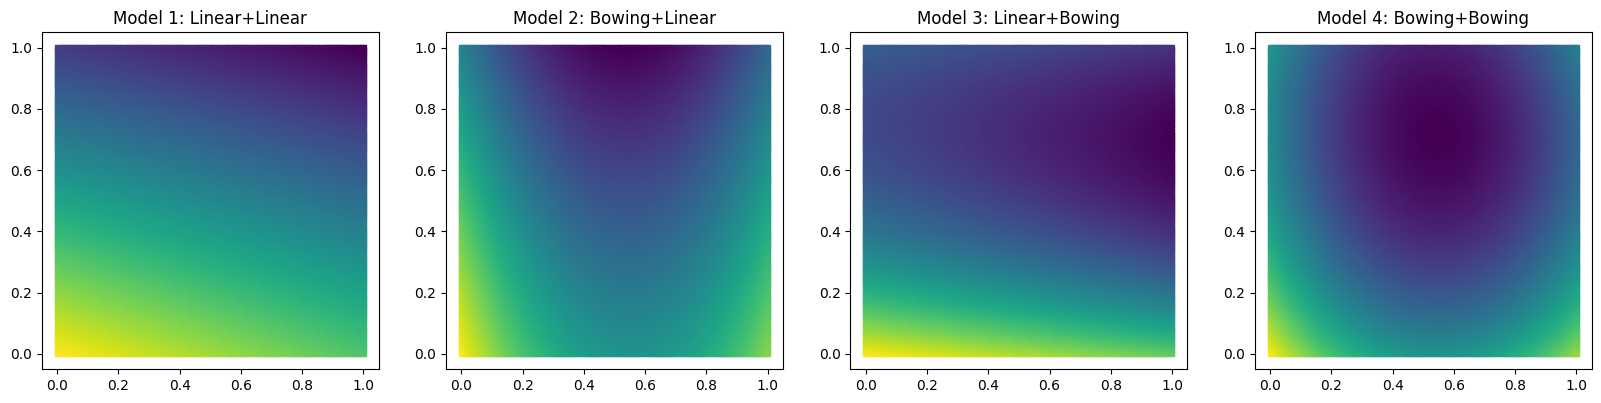

In [6]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5), dpi=100)
ax1.scatter(X[:, 0], X[:, 1], c=y1, marker='s', s=12)
ax1.set_title("Model 1: Linear+Linear")
ax1.set_aspect('equal')

ax2.scatter(X[:, 0], X[:, 1], c=y2, marker='s', s=12)
ax2.set_title("Model 2: Bowing+Linear")
ax2.set_aspect('equal')

ax3.scatter(X[:, 0], X[:, 1], c=y3, marker='s', s=12)
ax3.set_title("Model 3: Linear+Bowing")
ax3.set_aspect('equal')

ax4.scatter(X[:, 0], X[:, 1], c=y4, marker='s', s=12)
ax4.set_title("Model 4: Bowing+Bowing")
ax4.set_aspect('equal')

Define a general function for creating synthetic data:

In [7]:
def general_alloy(X, params):
    f1 = params["Ea1"] * X[:, 1] + params["Ea2"] * (1-X[:, 1]) - params["Kxa"] * (1-X[:, 1]) * X[:, 1]
    f2 = params["Eb1"] * X[:, 1] + params["Eb2"] * (1-X[:, 1]) - params["Kxb"] * (1-X[:, 1]) * X[:, 1]
    return f1 * X[:, 0] + f2 * (1 - X[:, 0]) - params["Ky"] * (1 - X[:, 0]) * X[:, 0]

Define grund truth parameters and "measurement" function:

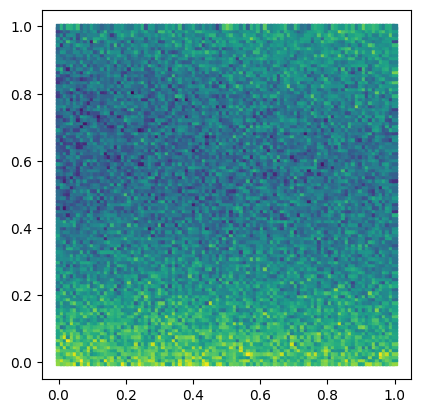

In [8]:
ground_truth_params = {"Ea1": 1.5, "Ea2": 1.8, "Eb1": 1.0,
                       "Eb2": 2.0, "Kxa": 3.0, "Kxb": 3.0,
                       "Ky": 0.0}

measure = lambda x: general_alloy(x, ground_truth_params) + .3 * np.random.randn(len(x))

#Generate synthetic data:
y = measure(X)

_, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=y, marker='s', s=12)
ax.set_aspect('equal')

Define simple mean functions and set corresponding priors over their parameters.

In [9]:
def mean_fn_1(X, params):
    return params["a"] + params["b"]*X[:, 0] + params["c"]*X[:, 1]

def mean_fn_1_prior():
    a = numpyro.sample("a", distributions.Normal(0, 1))
    b = numpyro.sample("b", distributions.Normal(1, 1))
    c = numpyro.sample("c", distributions.Normal(-5, 5))
    return {"a": a, "b": b, "c": c}

def mean_fn_2(X, params):
    return jnp.exp(-4*jnp.log(2) * ((X[:,0]-params["x0"])**2 + (X[:,1]-params["y0"])**2) / params["w"]**2)

def mean_fn_2_prior():
    x0 = numpyro.sample("x0", distributions.Normal(0.5, 0.1))
    y0 = numpyro.sample("y0", distributions.Normal(0, 0.1))
    w = numpyro.sample("w", distributions.HalfNormal(1.0))
    return {"x0": x0, "y0": y0, "w": w}

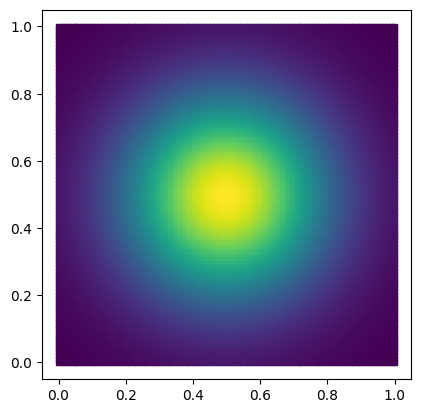

In [10]:
y_trial = mean_fn_2(X, {"x0": 0.5, "y0": 0.5, "w": 0.5})

_, ax = plt.subplots(dpi=100)
ax.scatter(X[:, 0], X[:, 1], c=y_trial, marker='s', s=12)
ax.set_aspect('equal')

Define a single sGP step:

In [11]:
def step_sGP(X_measured, y_measured, X_unmeasured,
             mean_fn, mean_fn_prior, kernel_prior=None, noise_prior=None):
    """Single sGP step"""
    jitter = 1e-6

    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()

    # Initialize model
    sgp_model = gpax.ExactGP(
        input_dim=2, kernel='RBF', kernel_prior=kernel_prior,
        mean_fn=mean_fn, mean_fn_prior=mean_fn_prior,
        noise_prior=noise_prior)

    # Run HMC to obtain posterior samples
    sgp_model.fit(
        rng_key1, X_measured, y_measured,
        num_warmup=300, num_samples=300, jitter=jitter)

    # Make a prediction
    y_pred, y_sampled = sgp_model.predict_in_batches(rng_key2, X_unmeasured, noiseless=True, jitter=jitter)

    # Return posterior mean and sampled predictions
    return y_pred, y_sampled

Initialize training data:

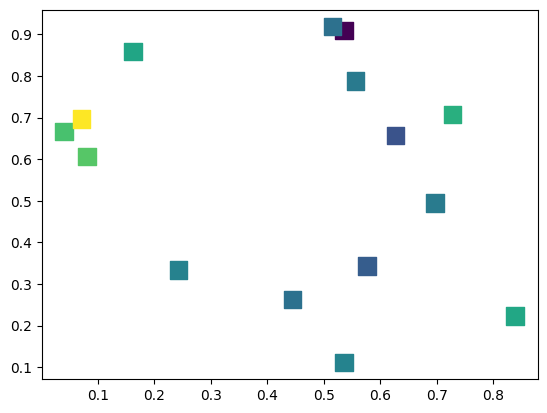

In [12]:
np.random.seed(42)

idx = np.random.randint(0, len(X), 15)
X_measured = X[idx]
y_measured = y[idx]
X_unmeasured = np.delete(X, idx, axis=0)

plt.scatter(X_measured[:, 1], X_measured[:, 0], c=y_measured, s=160, marker='s')

# Regular GP

Run **regular** GP:

sample: 100%|██████████| 600/600 [00:05<00:00, 111.21it/s, 7 steps of size 6.43e-01. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      2.43      2.57      1.67      0.25      5.19    210.07      1.00
k_length[1]      1.66      1.95      0.97      0.20      3.82    214.33      1.00
    k_scale      1.52      1.43      1.14      0.16      3.01    153.37      1.01
      noise      0.19      0.10      0.17      0.05      0.32    223.30      1.01



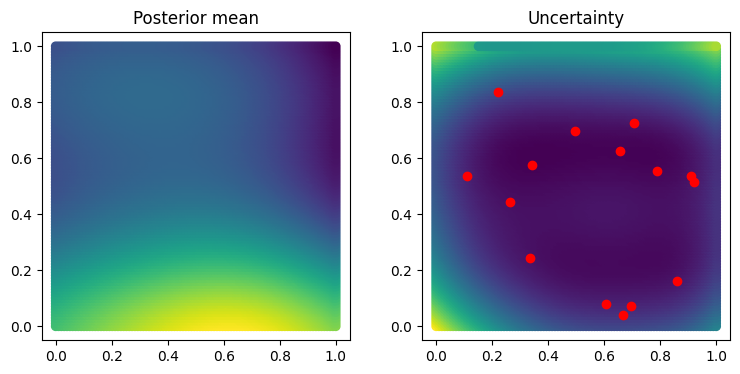

sample: 100%|██████████| 600/600 [00:05<00:00, 110.92it/s, 15 steps of size 4.87e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      3.11      3.23      2.46      0.34      5.90    139.49      1.00
k_length[1]      1.09      1.14      0.73      0.17      2.16    164.56      1.01
    k_scale      1.69      1.71      1.20      0.19      3.25    115.72      1.00
      noise      0.19      0.12      0.15      0.04      0.35    120.02      1.02



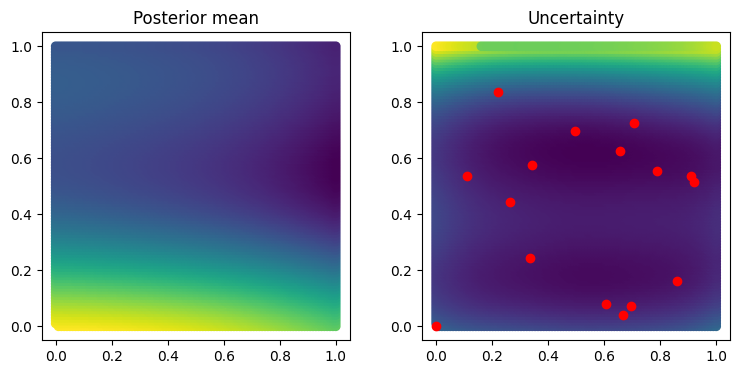

sample: 100%|██████████| 600/600 [00:06<00:00, 94.25it/s, 7 steps of size 4.28e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      2.95      2.38      2.46      0.52      5.33    156.82      1.01
k_length[1]      1.01      0.92      0.70      0.20      2.26    212.14      1.00
    k_scale      1.67      1.48      1.22      0.22      3.47    174.07      1.00
      noise      0.18      0.13      0.15      0.03      0.33    122.49      1.04



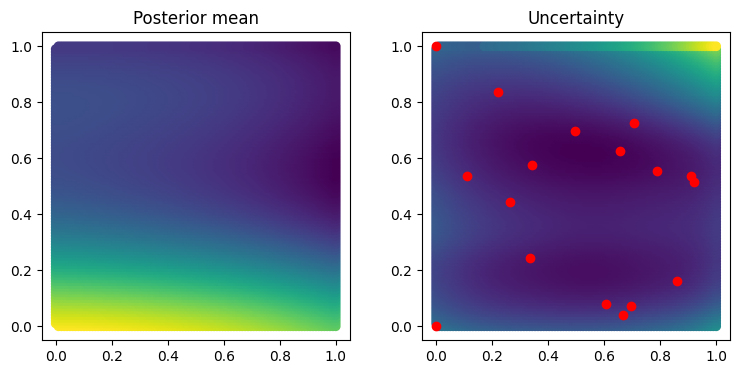

In [13]:
num_steps = 3

for e in range(num_steps):

    # Run GP
    y_pred, y_sampled = step_sGP(
        X_measured, y_measured, X_unmeasured,
        None, None)

    # Compute uncertainty
    U_f = y_sampled.squeeze().var(0)

    # Plot sGP prediction and uncertainty for the unmeasured parts of the compositional space
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=100)
    ax1.scatter(X_unmeasured[:, 0], X_unmeasured[:, 1], c=y_pred)
    ax1.set_title("Posterior mean")
    ax1.set_aspect('equal')
    ax2.scatter(X_unmeasured[:, 0], X_unmeasured[:, 1], c=U_f)
    ax2.scatter(X_measured[:,0], X_measured[:,1], c = 'r')
    ax2.set_title("Uncertainty")
    ax2.set_aspect('equal')
    plt.show()

    # Get the next measurement point
    next_idx = U_f.argmax(0)
    next_point = X_unmeasured[next_idx]

    # Make a measurement and update arrays
    measured_point = measure(next_point[None])
    y_measured = np.append(y_measured, measured_point)
    X_measured = np.append(X_measured, next_point[None], axis=0)
    X_unmeasured = np.delete(X_unmeasured, next_idx, axis=0)

Plot final results over the entire parameter space (measured+unmeasured points):

sample: 100%|██████████| 600/600 [00:06<00:00, 96.04it/s, 7 steps of size 5.58e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      3.50      3.20      2.58      0.57      7.27    120.29      1.00
k_length[1]      1.08      1.28      0.61      0.20      2.26     99.61      1.03
    k_scale      1.57      1.30      1.22      0.16      2.99    131.53      1.00
      noise      0.17      0.12      0.14      0.04      0.31     85.95      1.05



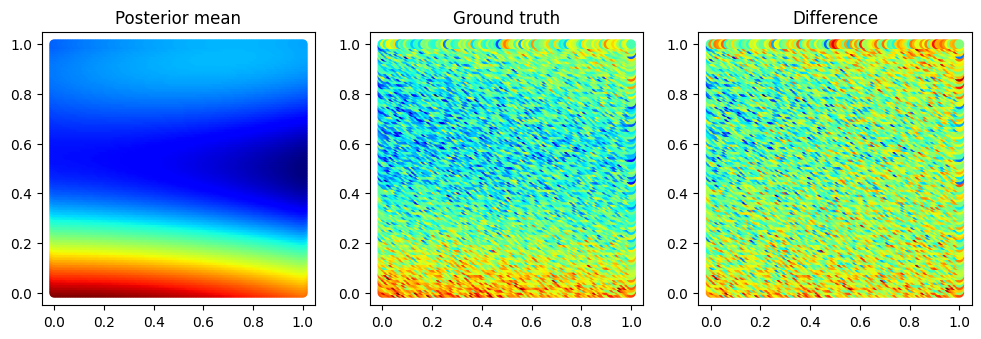

In [14]:
y_pred, y_sampled = step_sGP(
        X_measured, y_measured, X,
        None, None)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
ax1.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='jet')
ax1.set_title("Posterior mean")
ax1.set_aspect('equal')
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
ax2.set_title("Ground truth")
ax2.set_aspect('equal')
ax3.scatter(X[:, 0], X[:, 1], c=y-y_pred, cmap='jet')
ax3.set_title("Difference")
ax3.set_aspect('equal')
plt.show()

# Structured GP

Now run **structured** GP with a (very) crude model of system's behavior:

In [15]:
np.random.seed(42)
idx = np.random.randint(0, len(X),15)
X_measured = X[idx]
y_measured = y[idx]
X_unmeasured = np.delete(X, idx, axis=0)

sample: 100%|██████████| 600/600 [00:08<00:00, 73.67it/s, 3 steps of size 5.70e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      2.37      2.50      1.64      0.11      5.08    191.10      1.00
k_length[1]      2.17      2.08      1.52      0.21      5.12    284.03      1.00
    k_scale      0.90      0.76      0.66      0.10      1.85    350.53      1.00
      noise      0.17      0.08      0.15      0.06      0.29    259.48      1.00
          w      0.91      0.58      0.75      0.11      1.79    302.60      1.00
         x0      0.54      0.10      0.54      0.39      0.73    248.96      1.00
         y0     -0.02      0.09     -0.02     -0.16      0.13    372.46      1.00



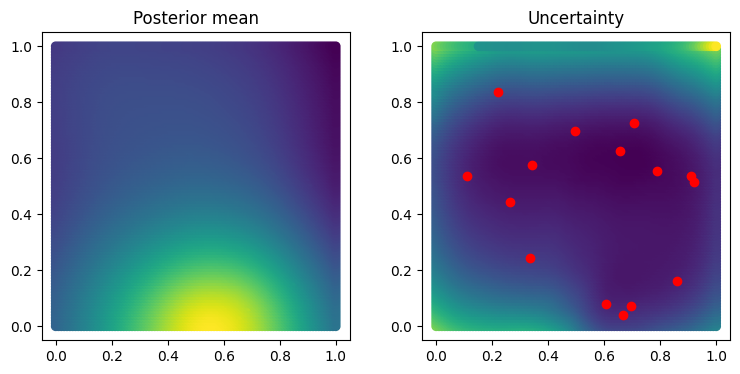

sample: 100%|██████████| 600/600 [00:09<00:00, 66.21it/s, 7 steps of size 4.02e-01. acc. prob=0.92]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      2.69      2.25      1.91      0.37      5.61    217.43      1.00
k_length[1]      1.80      1.82      1.10      0.19      4.48    188.21      1.01
    k_scale      1.10      0.88      0.82      0.12      2.40    189.71      1.00
      noise      0.17      0.09      0.15      0.05      0.32    212.25      1.02
          w      0.88      0.59      0.72      0.09      1.83    133.21      1.00
         x0      0.54      0.10      0.54      0.40      0.72    167.40      1.01
         y0     -0.01      0.09     -0.02     -0.14      0.14    307.14      1.00



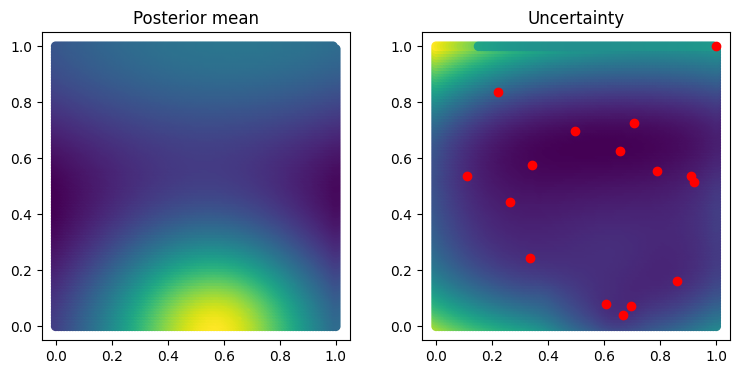

sample: 100%|██████████| 600/600 [00:09<00:00, 64.21it/s, 7 steps of size 4.25e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      3.04      3.47      2.14      0.24      6.22    168.87      1.00
k_length[1]      2.06      2.14      1.24      0.20      4.87    144.95      1.01
    k_scale      1.01      0.89      0.67      0.13      2.17    109.63      1.04
      noise      0.17      0.08      0.16      0.06      0.30    208.24      1.01
          w      0.83      0.57      0.65      0.12      1.74    170.66      1.01
         x0      0.53      0.10      0.54      0.38      0.71    175.63      1.00
         y0     -0.01      0.09     -0.01     -0.17      0.12    255.81      1.00



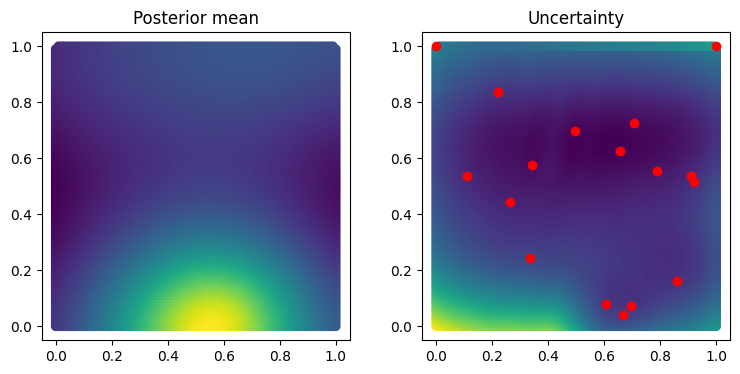

In [16]:
num_steps = 3

for e in range(num_steps):
    # Run sGP
    y_pred, y_sampled = step_sGP(
        X_measured, y_measured, X_unmeasured,
        mean_fn_2, mean_fn_2_prior)
    # Compute uncertainty
    U_f = y_sampled.squeeze().var(0)

    # Plot sGP prediction and uncertainty for the unmesured parts of the compositional space
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=100)
    ax1.scatter(X_unmeasured[:, 0], X_unmeasured[:, 1], c=y_pred)
    ax1.set_title("Posterior mean")
    ax1.set_aspect('equal')
    ax2.scatter(X_unmeasured[:, 0], X_unmeasured[:, 1], c=U_f)
    ax2.scatter(X_measured[:,0], X_measured[:,1], c = 'r')
    ax2.set_title("Uncertainty")
    ax2.set_aspect('equal')
    plt.show()

    # Get the next measurement point
    next_idx = U_f.argmax(0)
    next_point = X_unmeasured[next_idx]

    # Make a measurement and update arrays
    measured_point = measure(next_point[None])
    y_measured = np.append(y_measured, measured_point)
    X_measured = np.append(X_measured, next_point[None], axis=0)
    X_unmeasured = np.delete(X_unmeasured, next_idx, axis=0)

Plot final results over the entire parameter space (measured+unmeasured points):

In [17]:
X_measured.shape

(18, 2)

sample: 100%|██████████| 600/600 [00:09<00:00, 63.53it/s, 7 steps of size 4.38e-01. acc. prob=0.88]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      3.28      3.31      2.42      0.16      5.96     98.18      1.00
k_length[1]      1.61      1.79      0.81      0.17      4.43    136.33      1.00
    k_scale      1.14      0.99      0.84      0.15      2.39    224.82      1.02
      noise      0.18      0.10      0.17      0.05      0.31    142.85      1.00
          w      0.95      0.70      0.80      0.02      1.94     95.37      1.02
         x0      0.49      0.10      0.49      0.34      0.66    130.40      1.02
         y0     -0.03      0.09     -0.03     -0.18      0.12    239.70      1.00



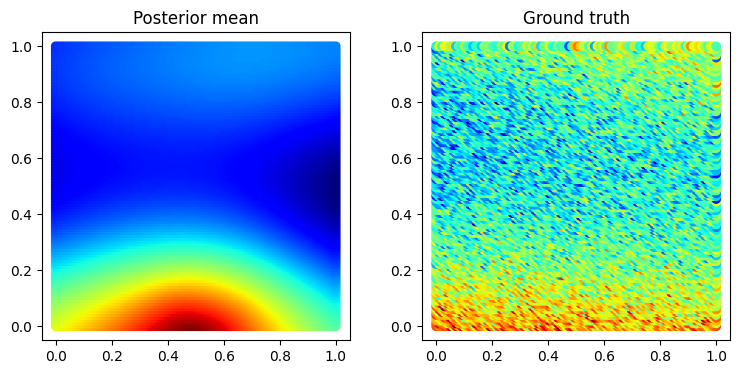

In [18]:
y_pred, y_sampled = step_sGP(
        X_measured, y_measured, X,
        mean_fn_2, mean_fn_2_prior)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=100)
ax1.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='jet')
ax1.set_title("Posterior mean")
ax1.set_aspect('equal')
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
ax2.set_title("Ground truth")
ax2.set_aspect('equal')
plt.show()

# Hypothesis learning

Define models:


In [19]:
from typing import Union, Dict, Type
import jax.random as jra

In [20]:
#def model1a(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
def model1a(X, params):
    f_apcd_linear = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky1"]*(1-y)*y
    f_apcd_bowing = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky2"]*(1-y)*y
    f_ll = lambda x, y: f_apcd_linear(y)*x + f_bpcd_linear(y)*(1-x) - params["kx1"]*(1-x)*x
    y1 = f_ll(X[:,0], X[:,1])
    return y1

def model2a(X: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    f_apcd_linear = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky1"]*(1-y)*y
    f_apcd_bowing = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky2"]*(1-y)*y
    f_bl = lambda x, y: f_apcd_linear(y)*x + f_bpcd_linear(y)*(1-x) - params["kx2"]*(1-x)*x
    y2 = f_bl(X[:,0], X[:,1])
    return y2

def model3a(X: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    f_apcd_linear = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky1"]*(1-y)*y
    f_apcd_bowing = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky2"]*(1-y)*y
    f_lb = lambda x, y: f_apcd_bowing(y)*x + f_bpcd_bowing(y)*(1-x)  - params["kx3"]*(1-x)*x
    y3 = f_lb(X[:,0], X[:,1])
    return y3

def model4a(X: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    f_apcd_linear = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky1"]*(1-y)*y
    f_apcd_bowing = lambda y: params["E_apc"]*y + params["E_apd"]*(1-y) - params["ky2"]*(1-y)*y
    f_bb = lambda x, y: f_apcd_bowing(y)*x + f_bpcd_bowing(y)*(1-x) - params["kx4"]*(1-x)*x
    y4 = f_bb(X[:,0], X[:,1])
    return y4

In [21]:
model1a

<function __main__.model1a(X, params)>

In [22]:
def model1a_priors():
    E_apc = numpyro.sample("E_apc", numpyro.distributions.Normal(0, 1))
    E_apd = numpyro.sample("E_apd", numpyro.distributions.LogNormal(0, 1))
    kx1 = numpyro.sample("kx1", numpyro.distributions.Normal(0, 1))
    ky1 = numpyro.sample("ky1", numpyro.distributions.LogNormal(0, 1))
    return {"E_apc": E_apc, "E_apd": E_apd, "kx1": kx1, "ky1": ky1}

def model2a_priors() -> Dict[str, jnp.ndarray]:
    E_apc = numpyro.sample("E_apc", numpyro.distributions.Normal(0, 1))
    E_apd = numpyro.sample("E_apd", numpyro.distributions.LogNormal(0, 1))
    kx2 = numpyro.sample("kx2", numpyro.distributions.LogNormal(0, 1))
    ky1 = numpyro.sample("ky1", numpyro.distributions.Normal(0, 1))
    ky2 = numpyro.sample("ky2", numpyro.distributions.LogNormal(0, 1))
    return {"E_apc": E_apc, "E_apd": E_apd, "kx2": kx2, "ky1": ky1, "ky2": ky2}

def model3a_priors() -> Dict[str, jnp.ndarray]:
    E_apc = numpyro.sample("E_apc", numpyro.distributions.Normal(0, 1))
    E_apd = numpyro.sample("E_apd", numpyro.distributions.LogNormal(0, 1))
    kx3 = numpyro.sample("kx3", numpyro.distributions.Normal(0, 1))
    ky1 = numpyro.sample("ky1", numpyro.distributions.LogNormal(0, 1))
    ky2 = numpyro.sample("ky2", numpyro.distributions.LogNormal(0, 1))
    return {"E_apc": E_apc, "E_apd": E_apd, "kx3": kx3, "ky1": ky1, "ky2": ky2}

def model4a_priors() -> Dict[str, jnp.ndarray]:
    E_apc = numpyro.sample("E_apc", numpyro.distributions.Normal(0, 1))
    E_apd = numpyro.sample("E_apd", numpyro.distributions.LogNormal(0, 1))
    kx4 = numpyro.sample("kx4", numpyro.distributions.Normal(0, 1))
    ky1 = numpyro.sample("ky1", numpyro.distributions.LogNormal(0, 1))
    ky2 = numpyro.sample("ky2", numpyro.distributions.LogNormal(0, 1))
    return {"E_apc": E_apc, "E_apd": E_apd, "kx4": kx4, "ky1": ky1, "ky2": ky2}

Define utility functions for the hypothsis learning:

In [23]:
def get_best_model(record):
    return record[:,1].argmax()

def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    if jnp.nanmedian(obj) < obj_history[-1]:  # one can use integral uncertainty instead of median
        r = 1
    else:
        r = -1
    return r

def step(model, model_prior, X_train, y_train, X_new=None, num_restarts=1, **kwargs):
    """Compute model posterior and use it to derive acqusition function"""
    verbose = kwargs.get("print_summary", True)
    sgr = numpyro.diagnostics.split_gelman_rubin
    for i in range(num_restarts):
        rng_key, rng_key_predict = gpax.utils.get_keys(i)
        # Get/update model posterior. In the paper, we used
        # num_samples = num_warmup = 5000 but that takes some time
        gp_model = gpax.ExactGP(
            2, 'Matern', mean_fn=model, mean_fn_prior=model_prior)
        gp_model.fit(
            rng_key, X_train, y_train, num_warmup=200,
            num_samples=200, num_chains=1, print_summary=verbose)
        rhats = [sgr(v).max() for v in gp_model.get_samples(1).values()]
        if max(rhats) < 1.1:
            break
    # Compute acquisition function
    obj = 0
    if X_new is not None:
        _, samples = gp_model.predict_in_batches(
            rng_key_predict, X_new, batch_size=500)
    return samples.squeeze().mean(0), gp_model

def update_datapoints(next_point_idx, X_train, y_train, X_test, y_test):
    """Update "measured" dummy data points"""
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, y_test[next_point_idx])
    y_test = jnp.delete(y_test, next_point_idx)
    return X_train, y_train, X_test, y_test

Re-generate seed data:

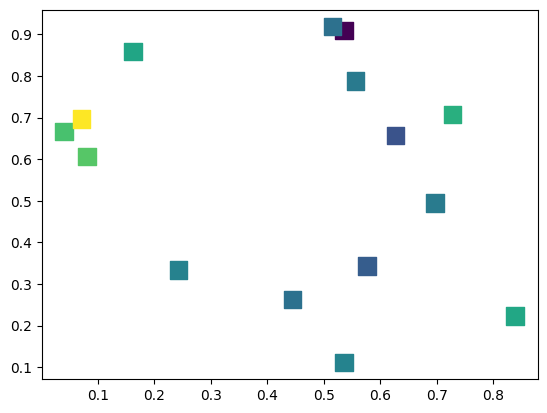

In [24]:
np.random.seed(42)
idx = np.random.randint(0, len(X), 15)
X_measured = X[idx]
y_measured = y[idx]
X_unmeasured = np.delete(X, idx, axis=0)
y_unmeasured = np.delete(y, idx, axis=0)

plt.scatter(X_measured[:, 1], X_measured[:, 0], c=y_measured, s=160, marker='s')

Run hypothesis learning:

In [25]:
exploration_steps = 30

eps = 0.25
warmup_steps = 3
models = [model1a, model2a, model3a, model4a]
model_priors = [model1a_priors, model2a_priors, model3a_priors, model4a_priors]

np.random.seed(55)  # rng seed for epsilon-greedy sampling
record = np.zeros((len(models), 2))
model_choices = []
obj_history = []

# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []

    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):
        # for each model, run BI and store uncertainty values
        obj, _ = step(model, model_priors[i], X_measured, y_measured, X)
        record[i, 0] += 1
        obj_all.append(obj)
        obj_median_all.append(jnp.nanmedian(obj).item())  # (one can use integral uncertainty instead of median)

    # 'Reward' a model that has the smallest integral/median uncertainty
    idx = np.argmin(obj_median_all)
    model_choices.append(idx)
    record[idx, 1] += 1

    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])

    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()

    # Evaluate the function in the suggested point - one may replace it with computing the actual function in this point
    measured_point = y_unmeasured[next_point_idx]

    # Update training/test data
    X_measured, y_measured, X_unmeasured, y_unmeasured = update_datapoints(
        next_point_idx, X_measured, y_measured, X_unmeasured, y_unmeasured
    )

# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))

    # Choose model according to epsilon-greedy policy
    if np.random.random() > eps:
        idx = get_best_model(record)
    else:
        idx = np.random.randint(len(models))
    model_choices.append(idx)
    print("Using model {}".format(idx+1))

    # Derive acqusition function with the selected model
    obj, m_post = step(models[idx], model_priors[idx], X_measured, y_measured, X_unmeasured, num_restarts=2)

    # Get reward
    r = get_reward(obj_history, obj)

    # Update records
    record = update_record(record, idx, r)
    obj_history.append(jnp.nanmedian(obj).item())

    # Evaluate function in the suggested point - one may repalce it with computing an actual function in next_point_idx
    next_point_idx = obj.argmax()
    measured_point = y_unmeasured[next_point_idx]

    # Update training/test data
    X_measured, y_measured, X_unmeasured, y_unmeasured = update_datapoints(
        next_point_idx, X_measured, y_measured, X_unmeasured, y_unmeasured
    )

Warmup step 1/3


sample: 100%|██████████| 400/400 [00:07<00:00, 55.48it/s, 15 steps of size 2.98e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.39      0.72      0.35     -0.69      1.74    167.90      0.99
      E_apd      1.38      0.80      1.22      0.27      2.65    134.36      1.00
k_length[0]      1.53      1.68      0.90      0.16      3.69    216.02      1.00
k_length[1]      1.83      1.99      1.16      0.19      4.12    139.47      1.01
    k_scale      0.97      0.96      0.74      0.09      1.96    226.78      1.00
        kx1     -0.17      0.95     -0.23     -1.74      1.16    165.33      1.00
        ky1      1.62      1.40      1.08      0.12      3.75    145.38      1.00
      noise      0.16      0.09      0.14      0.06      0.27    159.76      1.01



sample: 100%|██████████| 400/400 [00:06<00:00, 63.99it/s, 7 steps of size 4.31e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.33      0.83      0.30     -1.13      1.52    108.05      1.01
      E_apd      1.37      0.79      1.33      0.11      2.44     97.91      1.00
k_length[0]      1.59      1.61      1.03      0.07      3.50    144.05      1.02
k_length[1]      1.69      2.63      0.95      0.14      3.40    150.89      1.01
    k_scale      0.86      0.83      0.57      0.07      1.85    211.76      1.01
        kx2      0.94      0.77      0.77      0.09      1.75    193.58      1.02
        ky1      0.18      0.99      0.14     -1.51      1.68    294.37      1.00
        ky2      1.67      2.26      1.11      0.15      3.42    150.11      1.00
      noise      0.18      0.12      0.16      0.06      0.33    103.90      1.00



sample: 100%|██████████| 400/400 [00:06<00:00, 65.39it/s, 7 steps of size 4.91e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.50      0.75      0.51     -0.65      1.74    216.12      1.00
      E_apd      1.29      0.73      1.26      0.13      2.14    144.54      1.00
k_length[0]      1.94      2.69      1.13      0.21      4.08    163.72      1.00
k_length[1]      2.21      3.27      1.60      0.07      4.19    158.27      1.00
    k_scale      0.80      0.72      0.61      0.05      1.59    213.91      1.00
        kx3     -0.11      0.86     -0.07     -1.53      1.18    202.46      1.00
        ky1      1.74      1.86      1.07      0.11      4.17    146.53      1.00
        ky2      1.53      1.37      1.04      0.10      3.56    119.49      1.01
      noise      0.17      0.09      0.15      0.06      0.31    152.33      1.00



sample: 100%|██████████| 400/400 [00:07<00:00, 56.91it/s, 7 steps of size 4.91e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.50      0.75      0.51     -0.65      1.74    216.12      1.00
      E_apd      1.29      0.73      1.26      0.13      2.14    144.54      1.00
k_length[0]      1.94      2.69      1.13      0.21      4.08    163.72      1.00
k_length[1]      2.21      3.27      1.60      0.07      4.19    158.27      1.00
    k_scale      0.80      0.72      0.61      0.05      1.59    213.91      1.00
        kx4     -0.11      0.86     -0.07     -1.53      1.18    202.46      1.00
        ky1      1.74      1.86      1.07      0.11      4.17    146.53      1.00
        ky2      1.53      1.37      1.04      0.10      3.56    119.49      1.01
      noise      0.17      0.09      0.15      0.06      0.31    152.33      1.00

Warmup step 2/3


sample: 100%|██████████| 400/400 [00:06<00:00, 62.71it/s, 15 steps of size 4.36e-01. acc. prob=0.84] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.62      0.69      0.60     -0.45      1.69    140.02      0.99
      E_apd      1.35      0.69      1.33      0.24      2.42    129.42      1.01
k_length[0]      1.66      1.62      1.10      0.09      3.58    118.36      1.01
k_length[1]      1.80      2.49      1.18      0.22      3.56     69.42      1.05
    k_scale      0.82      0.94      0.54      0.04      1.59    173.96      1.00
        kx1      0.03      0.81      0.10     -1.49      1.13    106.35      1.03
        ky1      1.58      1.43      1.11      0.07      3.47    189.36      1.02
      noise      0.16      0.10      0.14      0.03      0.28     96.02      1.00



sample: 100%|██████████| 400/400 [00:07<00:00, 54.70it/s, 15 steps of size 4.09e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.37      0.73      0.40     -0.92      1.31    190.10      1.00
      E_apd      1.46      0.70      1.42      0.15      2.40    130.64      1.02
k_length[0]      1.94      2.22      1.16      0.14      4.29     89.72      1.00
k_length[1]      1.68      2.95      0.93      0.11      3.36    198.03      1.01
    k_scale      0.66      0.51      0.49      0.06      1.44    124.34      1.00
        kx2      0.94      0.82      0.74      0.03      1.86    149.35      1.02
        ky1      0.16      0.99      0.26     -1.47      1.74    129.29      1.00
        ky2      1.65      2.37      1.02      0.07      2.99    159.97      1.00
      noise      0.18      0.11      0.15      0.05      0.32     90.65      1.02



sample: 100%|██████████| 400/400 [00:07<00:00, 54.77it/s, 7 steps of size 4.12e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.56      0.72      0.56     -0.36      2.04    102.18      1.02
      E_apd      1.26      0.65      1.28      0.24      2.22     72.62      1.01
k_length[0]      1.88      2.36      1.12      0.25      3.80    163.53      1.00
k_length[1]      2.12      2.10      1.37      0.29      4.80    203.99      1.00
    k_scale      0.63      0.57      0.46      0.06      1.38    206.46      1.00
        kx3     -0.09      0.85     -0.09     -1.36      1.34    168.80      1.00
        ky1      1.45      1.34      1.02      0.08      3.34    187.48      1.00
        ky2      1.49      1.27      1.05      0.13      2.91    198.42      1.00
      noise      0.15      0.08      0.12      0.05      0.26    177.83      1.00



sample: 100%|██████████| 400/400 [00:07<00:00, 53.15it/s, 7 steps of size 4.12e-01. acc. prob=0.92]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.56      0.72      0.56     -0.36      2.04    102.18      1.02
      E_apd      1.26      0.65      1.28      0.24      2.22     72.62      1.01
k_length[0]      1.88      2.36      1.12      0.25      3.80    163.53      1.00
k_length[1]      2.12      2.10      1.37      0.29      4.80    203.99      1.00
    k_scale      0.63      0.57      0.46      0.06      1.38    206.46      1.00
        kx4     -0.09      0.85     -0.09     -1.36      1.34    168.80      1.00
        ky1      1.45      1.34      1.02      0.08      3.34    187.48      1.00
        ky2      1.49      1.27      1.05      0.13      2.91    198.42      1.00
      noise      0.15      0.08      0.12      0.05      0.26    177.83      1.00

Warmup step 3/3


sample: 100%|██████████| 400/400 [00:05<00:00, 68.74it/s, 15 steps of size 3.78e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.59      0.75      0.56     -0.39      1.98    177.91      1.00
      E_apd      1.38      0.66      1.37      0.22      2.24    101.61      1.00
k_length[0]      1.71      2.31      1.04      0.08      3.86     62.31      1.02
k_length[1]      1.67      2.20      1.04      0.28      3.61    144.20      1.00
    k_scale      0.71      0.82      0.49      0.07      1.42    187.94      1.00
        kx1      0.15      0.79      0.13     -0.83      1.57    132.04      1.01
        ky1      1.54      1.27      1.16      0.11      3.54    205.88      1.00
      noise      0.15      0.08      0.13      0.05      0.25    189.56      1.00



sample: 100%|██████████| 400/400 [00:06<00:00, 63.44it/s, 7 steps of size 4.43e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.41      0.81      0.41     -0.99      1.58    150.09      1.00
      E_apd      1.41      0.68      1.46      0.17      2.29     92.47      1.00
k_length[0]      1.88      2.28      1.01      0.12      4.16    157.01      1.00
k_length[1]      1.67      2.84      0.96      0.18      3.57    157.39      1.00
    k_scale      0.70      0.65      0.51      0.07      1.54    173.45      1.00
        kx2      0.86      0.63      0.68      0.07      1.83    187.21      1.00
        ky1      0.21      0.97      0.30     -1.31      1.88    182.98      1.01
        ky2      1.50      1.75      0.99      0.10      3.08    165.58      1.00
      noise      0.16      0.09      0.13      0.05      0.28    126.51      1.00



sample: 100%|██████████| 400/400 [00:06<00:00, 63.18it/s, 15 steps of size 4.12e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.51      0.74      0.51     -0.74      1.64    181.95      1.00
      E_apd      1.26      0.68      1.25      0.10      2.20    143.61      1.01
k_length[0]      1.78      1.99      1.07      0.14      3.68    159.61      1.00
k_length[1]      2.25      3.26      1.32      0.16      4.74    155.37      1.00
    k_scale      0.70      0.62      0.50      0.04      1.45    185.20      1.00
        kx3      0.01      0.88      0.01     -1.19      1.54    168.69      1.00
        ky1      1.49      1.58      0.94      0.13      3.58    136.95      1.00
        ky2      1.53      1.33      1.09      0.08      3.18    171.93      1.00
      noise      0.13      0.07      0.12      0.04      0.22    139.80      1.00



sample: 100%|██████████| 400/400 [00:05<00:00, 70.73it/s, 15 steps of size 4.12e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.51      0.74      0.51     -0.74      1.64    181.95      1.00
      E_apd      1.26      0.68      1.25      0.10      2.20    143.61      1.01
k_length[0]      1.78      1.99      1.07      0.14      3.68    159.61      1.00
k_length[1]      2.25      3.26      1.32      0.16      4.74    155.37      1.00
    k_scale      0.70      0.62      0.50      0.04      1.45    185.20      1.00
        kx4      0.01      0.88      0.01     -1.19      1.54    168.69      1.00
        ky1      1.49      1.58      0.94      0.13      3.58    136.95      1.00
        ky2      1.53      1.33      1.09      0.08      3.18    171.93      1.00
      noise      0.13      0.07      0.12      0.04      0.22    139.80      1.00

Exploration step 4/30
Using model 4


sample: 100%|██████████| 400/400 [00:05<00:00, 71.11it/s, 15 steps of size 3.88e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.61      0.78      0.65     -0.76      1.73    148.27      1.00
      E_apd      1.21      0.63      1.23      0.15      2.09    137.38      1.00
k_length[0]      1.58      1.37      1.15      0.21      3.33    146.10      1.00
k_length[1]      2.20      2.93      1.64      0.27      4.61    175.64      1.00
    k_scale      0.68      0.63      0.50      0.04      1.29    229.92      1.00
        kx4      0.02      0.90      0.04     -1.46      1.35    171.77      1.00
        ky1      1.45      1.63      0.91      0.09      3.14    278.76      1.00
        ky2      1.63      1.44      1.19      0.12      3.69    107.52      1.00
      noise      0.12      0.06      0.11      0.03      0.19    139.26      1.00

Exploration step 5/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 67.84it/s, 7 steps of size 4.59e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.49      0.77      0.50     -0.94      1.65    176.24      1.02
      E_apd      1.42      0.66      1.46      0.26      2.28    116.62      1.00
k_length[0]      1.90      2.43      1.32      0.11      3.96    132.07      1.00
k_length[1]      1.40      2.86      0.74      0.11      3.25    154.73      1.00
    k_scale      0.73      0.72      0.49      0.07      1.48    196.02      1.00
        kx2      0.87      0.64      0.72      0.07      1.74    190.45      1.00
        ky1      0.20      0.98      0.32     -1.40      1.70     75.59      1.04
        ky2      1.46      1.98      0.94      0.12      3.11    131.26      0.99
      noise      0.12      0.07      0.11      0.03      0.21    140.49      1.00

Exploration step 6/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 71.98it/s, 15 steps of size 3.33e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.49      0.75      0.45     -0.60      1.84    171.79      1.00
      E_apd      1.43      0.72      1.50      0.13      2.30     59.92      1.06
k_length[0]      1.97      2.05      1.29      0.21      4.37    111.31      1.00
k_length[1]      1.57      3.47      0.68      0.13      3.56    144.52      1.02
    k_scale      0.66      0.56      0.49      0.06      1.39    189.12      1.00
        kx2      0.91      0.77      0.73      0.10      1.77    143.35      1.05
        ky1      0.16      0.95      0.16     -1.35      1.85    139.86      1.01
        ky2      1.46      2.22      0.83      0.07      2.92    160.31      0.99
      noise      0.12      0.06      0.11      0.04      0.21    170.68      1.02

Exploration step 7/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 64.39it/s, 7 steps of size 4.41e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.44      0.78      0.44     -1.05      1.43    168.27      1.00
      E_apd      1.45      0.74      1.53      0.18      2.46     87.65      0.99
k_length[0]      1.87      2.26      1.29      0.23      3.54    161.21      1.00
k_length[1]      1.25      1.74      0.70      0.17      2.54    128.68      1.02
    k_scale      0.80      0.70      0.55      0.08      1.78    141.63      1.00
        kx2      0.84      0.61      0.63      0.12      1.68    270.04      1.00
        ky1      0.16      0.99      0.06     -1.55      1.71    171.74      1.00
        ky2      1.63      2.04      1.05      0.12      3.47    124.06      1.00
      noise      0.11      0.06      0.09      0.04      0.18    167.99      1.00

Exploration step 8/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 62.62it/s, 15 steps of size 4.00e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.43      0.79      0.38     -1.00      1.50     74.35      1.02
      E_apd      1.33      0.72      1.37      0.11      2.26     86.21      1.01
k_length[0]      1.78      2.15      1.14      0.15      4.10    142.83      1.00
k_length[1]      1.45      2.30      0.74      0.19      3.03    153.63      1.01
    k_scale      0.71      0.65      0.55      0.06      1.54    164.10      1.00
        kx2      0.91      0.63      0.78      0.03      1.71    185.50      1.02
        ky1      0.18      0.91      0.27     -1.57      1.40    156.51      1.00
        ky2      1.47      1.91      0.81      0.05      3.32    158.56      1.00
      noise      0.12      0.07      0.10      0.04      0.20    152.34      1.00

Exploration step 9/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 68.70it/s, 7 steps of size 4.05e-01. acc. prob=0.91]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.43      0.76      0.48     -0.95      1.46     87.27      1.06
      E_apd      1.31      0.79      1.28      0.24      2.62     36.74      1.13
k_length[0]      1.83      2.29      1.17      0.07      4.46    117.49      1.02
k_length[1]      1.72      3.31      0.72      0.19      3.43     48.48      1.06
    k_scale      0.73      0.71      0.51      0.07      1.50    248.25      1.00
        kx2      0.91      0.69      0.76      0.13      1.80    158.39      1.01
        ky1      0.29      1.01      0.36     -1.09      2.11    198.05      1.00
        ky2      1.47      1.71      0.96      0.06      3.00    160.52      1.00
      noise      0.10      0.05      0.10      0.04      0.17    172.12      1.00



sample: 100%|██████████| 400/400 [00:06<00:00, 60.29it/s, 7 steps of size 3.95e-01. acc. prob=0.91]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.48      0.73      0.46     -0.50      1.80    129.06      1.00
      E_apd      1.41      0.67      1.43      0.29      2.40     93.67      1.00
k_length[0]      2.13      2.94      1.19      0.18      4.59     81.83      1.01
k_length[1]      1.12      1.70      0.64      0.12      2.53     98.41      1.03
    k_scale      0.66      0.59      0.49      0.08      1.39    172.37      1.01
        kx2      0.86      0.55      0.74      0.11      1.61    157.61      1.00
        ky1      0.13      0.94      0.22     -1.53      1.55    115.75      1.00
        ky2      1.70      1.96      0.97      0.03      3.63    222.10      1.00
      noise      0.10      0.05      0.09      0.04      0.17     96.41      1.03

Exploration step 10/30
Using model 3


sample: 100%|██████████| 400/400 [00:06<00:00, 64.44it/s, 15 steps of size 3.75e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.64      0.66      0.65     -0.40      1.70    136.59      1.01
      E_apd      1.20      0.61      1.16      0.16      1.98     48.08      1.00
k_length[0]      1.67      2.11      0.99      0.14      3.69     97.96      1.02
k_length[1]      2.06      3.26      1.20      0.18      4.36    147.21      1.00
    k_scale      0.59      0.55      0.41      0.04      1.54    182.06      1.00
        kx3      0.01      0.76     -0.02     -1.11      1.37    178.85      1.01
        ky1      1.67      1.86      0.99      0.11      3.89    219.23      1.00
        ky2      1.55      1.42      1.21      0.11      3.47    214.74      1.00
      noise      0.09      0.04      0.09      0.04      0.15    100.09      1.02

Exploration step 11/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 72.08it/s, 15 steps of size 3.29e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.51      0.77      0.46     -0.90      1.50    146.86      1.03
      E_apd      1.42      0.70      1.54      0.26      2.28     31.81      1.13
k_length[0]      2.25      2.67      1.39      0.14      5.12     99.64      1.03
k_length[1]      1.09      2.15      0.59      0.14      2.01    182.52      1.03
    k_scale      0.77      0.74      0.51      0.07      1.74    201.50      1.00
        kx2      0.96      0.68      0.78      0.13      1.91    229.31      1.00
        ky1      0.18      0.91      0.22     -1.45      1.47    246.66      1.00
        ky2      1.50      1.51      0.97      0.09      4.14    168.43      1.00
      noise      0.09      0.04      0.08      0.03      0.15    122.13      1.00



sample: 100%|██████████| 400/400 [00:06<00:00, 62.29it/s, 15 steps of size 4.03e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.46      0.72      0.55     -0.77      1.50    191.78      1.00
      E_apd      1.42      0.72      1.33      0.21      2.35     73.54      1.06
k_length[0]      1.79      1.86      1.20      0.09      3.91    134.98      1.00
k_length[1]      1.22      1.66      0.62      0.15      2.93    118.21      1.00
    k_scale      0.69      0.68      0.47      0.08      1.53    157.90      1.00
        kx2      0.87      0.61      0.70      0.11      1.63    105.56      1.00
        ky1      0.28      1.06      0.31     -1.54      1.77    133.10      1.00
        ky2      1.64      1.93      1.04      0.03      3.60    179.31      1.00
      noise      0.10      0.04      0.09      0.05      0.15     73.93      1.02

Exploration step 12/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 69.25it/s, 7 steps of size 4.33e-01. acc. prob=0.85] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.57      0.78      0.56     -0.84      1.61    102.48      1.01
      E_apd      1.36      0.68      1.39      0.20      2.33    164.83      1.03
k_length[0]      1.87      2.06      1.40      0.11      3.81    107.26      1.00
k_length[1]      1.29      3.13      0.68      0.13      2.13    124.87      1.01
    k_scale      0.80      0.83      0.53      0.06      1.82    147.55      1.00
        kx2      0.84      0.57      0.70      0.06      1.60    209.10      1.01
        ky1      0.28      0.98      0.25     -1.19      1.96    225.14      1.00
        ky2      1.68      2.50      0.96      0.08      3.18    105.17      1.00
      noise      0.09      0.04      0.08      0.03      0.15    112.15      1.00

Exploration step 13/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 70.06it/s, 15 steps of size 4.14e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.57      0.72      0.58     -0.57      1.75    196.94      1.00
      E_apd      1.49      0.65      1.48      0.27      2.37    107.46      1.03
k_length[0]      1.83      1.74      1.39      0.18      4.02    105.19      1.00
k_length[1]      0.93      0.97      0.57      0.15      2.24     52.19      0.99
    k_scale      0.69      0.70      0.45      0.09      1.40    222.03      1.01
        kx2      0.80      0.57      0.70      0.08      1.43    177.14      1.00
        ky1      0.25      1.03      0.27     -1.36      1.93    166.29      1.00
        ky2      1.62      2.21      0.98      0.09      3.45    134.88      1.00
      noise      0.08      0.03      0.07      0.03      0.12    119.39      1.01

Exploration step 14/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 57.24it/s, 15 steps of size 3.61e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.49      0.75      0.44     -0.67      1.84     97.75      1.02
      E_apd      1.40      0.70      1.40      0.14      2.31     40.27      1.10
k_length[0]      1.81      1.94      1.24      0.08      4.05    124.87      1.01
k_length[1]      1.14      1.75      0.64      0.12      2.35    175.16      1.02
    k_scale      0.74      0.78      0.53      0.11      1.71    208.77      1.00
        kx2      0.92      0.68      0.77      0.10      1.72    212.05      1.00
        ky1      0.23      0.87      0.27     -1.38      1.47    163.79      1.00
        ky2      1.40      1.42      0.88      0.07      3.24    232.60      1.00
      noise      0.09      0.04      0.08      0.04      0.14    119.43      1.07

Exploration step 15/30
Using model 4


sample: 100%|██████████| 400/400 [00:05<00:00, 69.11it/s, 15 steps of size 3.58e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.63      0.69      0.73     -0.39      1.82    229.10      1.00
      E_apd      1.30      0.66      1.30      0.21      2.20     79.45      1.04
k_length[0]      2.20      3.94      1.20      0.11      4.13     98.21      1.01
k_length[1]      1.84      1.81      1.21      0.19      4.18    127.96      1.00
    k_scale      0.62      0.69      0.43      0.08      1.46    109.25      1.02
        kx4      0.00      0.78     -0.02     -1.19      1.32    150.20      1.01
        ky1      1.43      1.41      0.95      0.08      3.42    204.61      1.00
        ky2      1.67      1.36      1.19      0.09      3.59    160.52      1.00
      noise      0.08      0.03      0.07      0.04      0.12    178.56      1.00

Exploration step 16/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 60.65it/s, 7 steps of size 3.61e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.39      0.76      0.38     -0.67      1.81    146.80      1.05
      E_apd      1.21      0.70      1.11      0.12      2.22     91.42      1.04
k_length[0]      1.44      2.86      0.79      0.12      2.63    172.39      1.02
k_length[1]      1.75      2.46      0.96      0.12      4.56    137.57      1.00
    k_scale      0.63      0.66      0.45      0.06      1.28    152.19      1.00
        kx2      0.93      0.67      0.79      0.06      1.69    152.28      1.01
        ky1      0.27      0.98      0.33     -1.46      1.64    200.57      1.00
        ky2      1.56      2.11      0.94      0.06      3.31    137.18      1.00
      noise      0.10      0.04      0.09      0.05      0.15    203.08      0.99

Exploration step 17/30
Using model 2


sample: 100%|██████████| 400/400 [00:05<00:00, 68.91it/s, 15 steps of size 3.75e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.30      0.74      0.25     -1.13      1.30    164.75      1.00
      E_apd      1.24      0.70      1.20      0.11      2.26     67.12      1.06
k_length[0]      1.25      1.54      0.74      0.13      2.42     82.62      1.01
k_length[1]      1.59      2.03      0.92      0.12      3.55    180.73      1.00
    k_scale      0.66      0.58      0.49      0.08      1.50    150.01      1.00
        kx2      1.00      0.79      0.80      0.07      1.95    190.98      1.01
        ky1      0.21      1.00      0.18     -1.40      1.80    186.31      1.00
        ky2      1.49      1.67      0.91      0.13      3.36    127.64      1.00
      noise      0.11      0.04      0.10      0.05      0.17     91.36      1.00

Exploration step 18/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 60.01it/s, 15 steps of size 3.51e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.42      0.74      0.39     -1.03      1.42    172.64      1.01
      E_apd      1.38      0.67      1.40      0.21      2.27    110.87      1.02
k_length[0]      1.78      2.98      0.99      0.15      3.64     77.90      1.00
k_length[1]      1.47      1.64      0.96      0.22      3.14    124.91      1.05
    k_scale      0.74      0.72      0.58      0.05      1.49    158.59      1.00
        kx2      0.97      0.73      0.77      0.08      2.08    173.45      1.00
        ky1      0.34      0.90      0.27     -0.98      1.95    289.40      1.00
        ky2      1.31      1.40      0.86      0.06      3.08    168.08      1.00
      noise      0.11      0.04      0.10      0.06      0.18    127.66      1.01

Exploration step 19/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 61.52it/s, 7 steps of size 4.20e-01. acc. prob=0.87]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.46      0.79      0.45     -0.98      1.52    152.86      1.00
      E_apd      1.39      0.74      1.35      0.15      2.43     22.64      1.06
k_length[0]      1.58      1.64      1.04      0.07      3.74     48.39      1.01
k_length[1]      1.50      2.77      0.81      0.11      2.75    206.13      1.01
    k_scale      0.70      0.67      0.48      0.08      1.61    164.49      1.01
        kx2      0.90      0.64      0.75      0.08      1.78    238.12      1.00
        ky1      0.36      0.87      0.41     -0.93      1.88    170.29      1.01
        ky2      1.68      2.46      0.96      0.15      3.63    150.59      1.00
      noise      0.10      0.03      0.09      0.05      0.15    105.87      1.00

Exploration step 20/30
Using model 2


sample: 100%|██████████| 400/400 [00:07<00:00, 52.79it/s, 15 steps of size 4.04e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.40      0.77      0.35     -0.90      1.67    129.88      1.02
      E_apd      1.33      0.80      1.26      0.10      2.38     69.53      1.04
k_length[0]      1.62      1.90      0.93      0.21      4.00    109.65      1.02
k_length[1]      1.46      2.09      0.79      0.17      2.72    105.12      1.00
    k_scale      0.79      0.74      0.54      0.09      1.80    189.98      1.00
        kx2      0.89      0.68      0.73      0.04      1.62    182.96      1.00
        ky1      0.24      1.02      0.27     -1.30      2.11    167.79      1.00
        ky2      1.51      2.14      0.98      0.07      2.93    149.97      1.00
      noise      0.10      0.03      0.09      0.04      0.14    134.80      0.99

Exploration step 21/30
Using model 2


sample: 100%|██████████| 400/400 [00:07<00:00, 52.94it/s, 15 steps of size 3.28e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.41      0.71      0.44     -0.79      1.41    199.62      1.02
      E_apd      1.35      0.67      1.37      0.15      2.29     51.94      1.08
k_length[0]      1.41      1.90      0.89      0.22      2.86    118.87      1.05
k_length[1]      1.46      2.30      0.82      0.16      3.67    179.85      1.02
    k_scale      0.70      0.70      0.47      0.08      1.68    177.09      1.00
        kx2      0.95      0.70      0.78      0.07      1.88    176.28      1.00
        ky1      0.29      0.94      0.30     -1.08      1.80    173.12      1.00
        ky2      1.55      1.75      1.02      0.09      3.53    145.48      1.00
      noise      0.10      0.03      0.09      0.05      0.14    195.49      1.00

Exploration step 22/30
Using model 2


sample: 100%|██████████| 400/400 [00:06<00:00, 59.75it/s, 15 steps of size 3.12e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.41      0.76      0.34     -0.79      1.64    161.48      1.02
      E_apd      1.33      0.75      1.31      0.21      2.43    143.26      1.02
k_length[0]      1.42      1.66      0.80      0.15      3.17     96.34      1.06
k_length[1]      1.46      1.96      0.81      0.13      3.15    173.61      1.00
    k_scale      0.66      0.60      0.49      0.08      1.27    181.52      1.00
        kx2      0.88      0.62      0.71      0.10      1.80    162.87      0.99
        ky1      0.21      0.98      0.18     -1.13      2.10    240.04      1.00
        ky2      1.51      1.94      1.02      0.06      2.86    166.72      1.00
      noise      0.10      0.03      0.09      0.05      0.16     90.75      1.05

Exploration step 23/30
Using model 2


sample: 100%|██████████| 400/400 [00:07<00:00, 52.53it/s, 15 steps of size 3.20e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.42      0.75      0.38     -0.78      1.62    158.31      1.01
      E_apd      1.31      0.70      1.26      0.16      2.20    100.99      1.02
k_length[0]      1.50      1.79      0.84      0.13      3.54    129.65      1.00
k_length[1]      1.28      1.34      0.80      0.17      2.71    168.44      1.00
    k_scale      0.79      0.84      0.52      0.05      1.81    112.66      1.00
        kx2      0.95      0.76      0.75      0.11      1.85    167.32      1.00
        ky1      0.27      0.86      0.32     -1.30      1.41    250.90      1.01
        ky2      1.35      1.39      1.02      0.06      2.82    163.28      1.00
      noise      0.09      0.03      0.09      0.05      0.13    159.44      1.00

Exploration step 24/30
Using model 1


sample: 100%|██████████| 400/400 [00:06<00:00, 61.34it/s, 15 steps of size 2.65e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.58      0.67      0.55     -0.45      1.61    124.54      1.00
      E_apd      1.33      0.63      1.34      0.21      2.17    103.84      1.00
k_length[0]      1.52      1.63      1.04      0.12      3.07    127.54      1.00
k_length[1]      1.46      1.79      0.90      0.23      3.12    140.08      1.00
    k_scale      0.78      0.68      0.59      0.07      1.61    142.29      1.00
        kx1      0.10      0.77      0.08     -1.25      1.13    171.72      1.00
        ky1      1.49      1.27      1.18      0.14      3.27    188.59      1.00
      noise      0.09      0.03      0.09      0.05      0.12    172.18      1.00

Exploration step 25/30
Using model 2


sample: 100%|██████████| 400/400 [00:08<00:00, 47.19it/s, 7 steps of size 3.86e-01. acc. prob=0.86]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.43      0.75      0.40     -0.74      1.73    151.21      1.02
      E_apd      1.54      0.77      1.62      0.14      2.51    130.31      1.00
k_length[0]      1.76      1.72      1.28      0.16      3.70    148.29      1.00
k_length[1]      1.24      1.93      0.69      0.13      2.44    163.02      1.01
    k_scale      0.80      0.78      0.57      0.07      1.72    135.33      1.00
        kx2      0.84      0.65      0.69      0.10      1.64    141.20      1.00
        ky1      0.15      0.92      0.10     -1.26      1.58    226.25      1.00
        ky2      1.55      1.94      0.97      0.06      3.29    173.95      1.00
      noise      0.10      0.03      0.09      0.06      0.14    167.82      1.00

Exploration step 26/30
Using model 2


sample: 100%|██████████| 400/400 [00:07<00:00, 51.39it/s, 15 steps of size 3.65e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.48      0.76      0.51     -0.78      1.58    118.82      1.02
      E_apd      1.53      0.75      1.56      0.29      2.55    131.86      1.00
k_length[0]      2.11      2.50      1.39      0.12      4.52     64.55      1.01
k_length[1]      1.47      2.68      0.72      0.15      3.16    146.98      1.02
    k_scale      0.78      0.79      0.55      0.13      1.81    138.18      1.01
        kx2      0.82      0.59      0.71      0.09      1.41    186.78      1.00
        ky1      0.36      0.87      0.33     -1.03      1.76    179.48      1.00
        ky2      1.66      2.35      0.99      0.07      3.49    155.32      0.99
      noise      0.09      0.03      0.08      0.05      0.14    100.47      1.00

Exploration step 27/30
Using model 1


sample: 100%|██████████| 400/400 [00:06<00:00, 60.01it/s, 15 steps of size 2.76e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.61      0.73      0.64     -0.74      1.62    208.55      1.00
      E_apd      1.39      0.70      1.29      0.37      2.52     72.84      1.02
k_length[0]      1.81      1.87      1.18      0.12      3.77    106.36      1.00
k_length[1]      1.49      1.58      0.88      0.19      3.16     64.20      1.00
    k_scale      0.81      0.91      0.56      0.13      1.59    165.06      1.01
        kx1     -0.04      0.80     -0.09     -1.43      1.06    136.96      1.01
        ky1      1.65      1.58      1.10      0.06      3.65     90.60      1.02
      noise      0.10      0.03      0.09      0.06      0.14    228.31      1.00

Exploration step 28/30
Using model 2


sample: 100%|██████████| 400/400 [00:07<00:00, 50.78it/s, 15 steps of size 3.02e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.49      0.78      0.52     -0.83      1.82    273.81      1.00
      E_apd      1.51      0.76      1.59      0.10      2.51     40.64      1.07
k_length[0]      2.03      1.93      1.46      0.32      4.24    123.98      1.02
k_length[1]      0.87      1.36      0.60      0.15      1.42    203.61      1.00
    k_scale      0.90      0.88      0.60      0.10      2.23    156.54      1.00
        kx2      0.75      0.51      0.61      0.09      1.52    292.06      1.00
        ky1      0.17      0.93      0.20     -1.33      1.69    241.70      1.00
        ky2      1.29      1.20      0.99      0.14      2.40    175.04      1.00
      noise      0.10      0.03      0.09      0.06      0.14    149.93      1.00

Exploration step 29/30
Using model 2


sample: 100%|██████████| 400/400 [00:08<00:00, 46.14it/s, 15 steps of size 2.57e-01. acc. prob=0.97] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.47      0.81      0.46     -0.79      1.75    180.76      1.00
      E_apd      1.41      0.76      1.47      0.13      2.45     35.64      1.11
k_length[0]      1.95      1.84      1.36      0.17      4.22     88.52      1.04
k_length[1]      1.03      1.47      0.64      0.15      1.78    100.49      1.00
    k_scale      0.96      1.03      0.62      0.09      2.19    133.38      1.00
        kx2      0.78      0.56      0.64      0.05      1.56    178.59      1.00
        ky1      0.15      1.04      0.18     -1.73      1.61    208.61      1.01
        ky2      1.65      2.20      1.02      0.17      3.49    186.48      1.00
      noise      0.10      0.03      0.09      0.06      0.14    173.52      1.00



sample: 100%|██████████| 400/400 [00:07<00:00, 55.51it/s, 7 steps of size 3.75e-01. acc. prob=0.94]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.47      0.72      0.43     -0.64      1.72    111.51      1.05
      E_apd      1.61      0.77      1.69      0.26      2.65     95.25      1.00
k_length[0]      2.06      1.83      1.53      0.19      4.40    104.89      1.00
k_length[1]      0.87      1.06      0.53      0.17      1.88     76.14      1.00
    k_scale      0.82      0.96      0.53      0.06      1.65    173.36      1.01
        kx2      0.68      0.42      0.59      0.11      1.26    164.80      1.02
        ky1      0.13      0.93      0.15     -1.26      1.60    100.95      1.01
        ky2      1.75      2.38      0.93      0.05      3.91    157.27      0.99
      noise      0.09      0.03      0.09      0.05      0.12    162.28      1.00

Exploration step 30/30
Using model 2


sample: 100%|██████████| 400/400 [00:08<00:00, 47.07it/s, 15 steps of size 3.63e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      E_apc      0.56      0.76      0.49     -0.64      1.77    220.52      1.01
      E_apd      1.67      0.74      1.74      0.40      2.68     55.29      1.04
k_length[0]      2.12      1.74      1.52      0.07      4.52    134.07      1.00
k_length[1]      0.88      1.76      0.56      0.13      1.43    145.96      1.00
    k_scale      0.85      0.90      0.57      0.12      1.87    145.50      1.00
        kx2      0.74      0.57      0.56      0.10      1.55    204.75      1.01
        ky1      0.21      0.87      0.22     -1.18      1.71    139.56      1.02
        ky2      1.57      2.31      0.96      0.07      3.23    182.16      1.00
      noise      0.09      0.03      0.09      0.05      0.12    134.11      0.99



In [26]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

model 1:  counts 5  reward (avg) -0.4
model 2:  counts 25  reward (avg) 0.52
model 3:  counts 4  reward (avg) -0.25
model 4:  counts 5  reward (avg) -0.4


We see that the model which received the highest reward (i.e., is
favored by our algorithm) clearly provided the best fit. Hence, we were able both to learn a correct data distribution with a small number of sparse measurements while also identifying a correct model that describes the system’s behavior.